In [1]:
#  Libraries used
import numpy as np
import pandas as pd
import plotly.express as px
import yfinance as yf
from yahoofinancials import YahooFinancials
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, CuDNNLSTM
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import scipy.stats as stats
import esig.tosig as ts
from sklearn.metrics import r2_score

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

tf.config.set_visible_devices([], 'GPU')

2024-01-19 21:36:36.658431: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-19 21:36:36.684456: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-19 21:36:37.190167: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-01-19 21:36:37.638512: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.

# Fetching data

In [2]:
ticker = 'QQQ'
yahoo_financials = YahooFinancials(ticker)
historical_stock_prices = yahoo_financials.get_historical_price_data('2023-01-01', '2023-12-31', 'daily')

In [3]:
prices = pd.DataFrame(historical_stock_prices[ticker]['prices'])
prices.set_index('formatted_date', inplace=True)
prices.index.name = 'Date'

# Data pre processing

In [4]:
np.random.seed(10)
tf.random.set_seed(21)

In [5]:
log_s = np.log(prices['adjclose'])[:-62]
log_v = np.log(prices['volume'])[:-62]
log_vol = np.log(prices['adjclose'].rolling(63).std()).dropna()

In [6]:
# Setting the hyperparameters
L = 10
M = 2
lambda_value = 1.0

In [7]:
# path calculation
z = []
for t in range(L, log_s.shape[0]):
    path_s = log_s[t-L:t]
    path_v = log_v[t-L:t]
    path_vol = log_vol[t-L:t]
    
    z.append(np.array([(t-L+tau, path_s[tau], path_v[tau], path_vol[tau]) for tau in range(L)]))
  

In [8]:
# signature transformation calculation
x = np.array([ts.stream2sig(zt, M) for zt in z])

# Featuring Data

In [9]:
x = x[:, :, np.newaxis]
y = log_s[L:]

In [10]:
# Splittting the data
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size, shuffle=False)

# Setting architecture

In [11]:
# Regularisation for source
def custom_regularization_term(weights, lambda_value):
    squared_value = tf.square(weights)
    return lambda_value * tf.reduce_sum(squared_value)

# Regularisation for task
def custom_loss(y_true, y_pred, lambda_value):
    mse_loss = MeanSquaredError()(y_true, y_pred)
    reg_loss = custom_regularization_term(model.trainable_weights[0], lambda_value)
    return mse_loss + reg_loss

In [12]:
# Inicialisation of NN
model = Sequential()  
model.add(LSTM(69, activation="tanh", recurrent_activation='sigmoid', return_sequences=True, 
               input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(LSTM(3, activation="tanh", return_sequences=True))
model.add(LSTM(98, activation="tanh", return_sequences=True))

# Adding Dense layer
model.add(Dense(98, activation='tanh'))

model.add(LSTM(6, activation="tanh"))
# Last layer
model.add(Dense(1))

2024-01-19 21:36:38.100116: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-19 21:36:38.101086: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-19 21:36:38.101745: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [13]:
# model compilation for training
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss=lambda y_true, y_pred: custom_loss(y_true, y_pred, lambda_value),
              metrics=['mse'])

# Base Learning

In [14]:
# Model fitting
history = model.fit(X_train, y_train, 
                    epochs=200, batch_size=30, validation_split=0.1, verbose=1)

Epoch 1/200


2024-01-19 21:36:38.577698: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-19 21:36:38.578756: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-19 21:36:38.579400: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2024-01-19 21:36:41.643251: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f9124027800 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-01-19 21:36:41.643281: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Host, Default Version
2024-01-19 21:36:41.647962: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-19 21:36:41.647996: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-19 21:36:41.670445: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4/4 [==============================] - ETA: 0s - loss: 33.2039 - mse: 31.3210 

2024-01-19 21:36:42.258307: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-19 21:36:42.259289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-19 21:36:42.260022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 4s 275ms/step - loss: 33.2039 - mse: 31.3210 - val_loss: 30.5354 - val_mse: 28.7358
Epoch 2/200
4/4 [==============================] - 0s 29ms/step - loss: 25.7159 - mse: 23.9543 - val_loss: 21.9979 - val_mse: 20.3061
Epoch 3/200
4/4 [==============================] - 0s 29ms/step - loss: 18.5990 - mse: 16.9434 - val_loss: 16.1164 - val_mse: 14.5302
Epoch 4/200
4/4 [==============================] - 0s 30ms/step - loss: 13.2543 - mse: 11.7050 - val_loss: 11.6368 - val_mse: 10.1579
Epoch 5/200
4/4 [==============================] - 0s 32ms/step - loss: 9.7992 - mse: 8.3574 - val_loss: 9.3521 - val_mse: 7.9808
Epoch 6/200
4/4 [==============================] - 0s 32ms/step - loss: 8.0727 - mse: 6.7380 - val_loss: 8.2361 - val_mse: 6.9702
Epoch 7/200
4/4 [==============================] - 0s 32ms/step - loss: 7.2270 - mse: 5.9964 - val_loss: 7.6612 - val_mse: 6.4965
Epoch 8/200
4/4 [==============================] - 0s 36ms/step - loss: 6.7627 - mse:

4/4 [==============================] - 0s 31ms/step - loss: 1.0020 - mse: 0.9991 - val_loss: 1.3070 - val_mse: 1.3043
Epoch 64/200
4/4 [==============================] - 0s 33ms/step - loss: 0.9669 - mse: 0.9643 - val_loss: 1.2673 - val_mse: 1.2649
Epoch 65/200
4/4 [==============================] - 0s 29ms/step - loss: 0.9331 - mse: 0.9307 - val_loss: 1.2287 - val_mse: 1.2264
Epoch 66/200
4/4 [==============================] - 0s 31ms/step - loss: 0.9002 - mse: 0.8980 - val_loss: 1.1911 - val_mse: 1.1891
Epoch 67/200
4/4 [==============================] - 0s 30ms/step - loss: 0.8682 - mse: 0.8663 - val_loss: 1.1546 - val_mse: 1.1527
Epoch 68/200
4/4 [==============================] - 0s 32ms/step - loss: 0.8374 - mse: 0.8355 - val_loss: 1.1191 - val_mse: 1.1173
Epoch 69/200
4/4 [==============================] - 0s 32ms/step - loss: 0.8074 - mse: 0.8057 - val_loss: 1.0846 - val_mse: 1.0830
Epoch 70/200
4/4 [==============================] - 0s 29ms/step - loss: 0.7782 - mse: 0.7767 - 

4/4 [==============================] - 0s 29ms/step - loss: 0.0762 - mse: 0.0761 - val_loss: 0.1753 - val_mse: 0.1752
Epoch 126/200
4/4 [==============================] - 0s 32ms/step - loss: 0.0727 - mse: 0.0726 - val_loss: 0.1699 - val_mse: 0.1698
Epoch 127/200
4/4 [==============================] - 0s 34ms/step - loss: 0.0694 - mse: 0.0692 - val_loss: 0.1647 - val_mse: 0.1645
Epoch 128/200
4/4 [==============================] - 0s 35ms/step - loss: 0.0662 - mse: 0.0661 - val_loss: 0.1596 - val_mse: 0.1595
Epoch 129/200
4/4 [==============================] - 0s 32ms/step - loss: 0.0631 - mse: 0.0630 - val_loss: 0.1548 - val_mse: 0.1546
Epoch 130/200
4/4 [==============================] - 0s 37ms/step - loss: 0.0603 - mse: 0.0601 - val_loss: 0.1501 - val_mse: 0.1500
Epoch 131/200
4/4 [==============================] - 0s 31ms/step - loss: 0.0575 - mse: 0.0574 - val_loss: 0.1455 - val_mse: 0.1454
Epoch 132/200
4/4 [==============================] - 0s 32ms/step - loss: 0.0549 - mse: 0.

4/4 [==============================] - 0s 44ms/step - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0400 - val_mse: 0.0399
Epoch 188/200
4/4 [==============================] - 0s 41ms/step - loss: 0.0071 - mse: 0.0071 - val_loss: 0.0394 - val_mse: 0.0394
Epoch 189/200
4/4 [==============================] - 0s 41ms/step - loss: 0.0070 - mse: 0.0069 - val_loss: 0.0389 - val_mse: 0.0388
Epoch 190/200
4/4 [==============================] - 0s 44ms/step - loss: 0.0068 - mse: 0.0068 - val_loss: 0.0383 - val_mse: 0.0383
Epoch 191/200
4/4 [==============================] - 0s 37ms/step - loss: 0.0068 - mse: 0.0067 - val_loss: 0.0378 - val_mse: 0.0378
Epoch 192/200
4/4 [==============================] - 0s 39ms/step - loss: 0.0066 - mse: 0.0066 - val_loss: 0.0373 - val_mse: 0.0373
Epoch 193/200
4/4 [==============================] - 0s 39ms/step - loss: 0.0066 - mse: 0.0065 - val_loss: 0.0369 - val_mse: 0.0368
Epoch 194/200
4/4 [==============================] - 0s 38ms/step - loss: 0.0065 - mse: 0.

In [15]:
# Model prediction
y_pred = model.predict(X_test)

2024-01-19 21:37:08.231913: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-19 21:37:08.234407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-19 21:37:08.236362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 10ms/step


In [16]:
print('Mean Squared Error:',mean_squared_error(y_pred, y_test))

Mean Squared Error: 0.03389874006531519


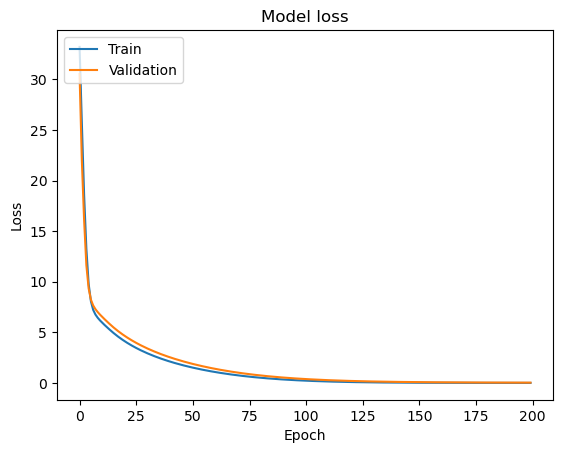

In [17]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Transfer learning

In [18]:
ticker = 'AAPL'
yahoo_financials = YahooFinancials(ticker)
historical_stock_prices = yahoo_financials.get_historical_price_data('2023-01-01', '2023-12-31', 'daily')

prices = pd.DataFrame(historical_stock_prices[ticker]['prices'])
prices.set_index('formatted_date', inplace=True)
prices.index.name = 'Date'

In [19]:

log_s = np.log(prices['adjclose'])
log_v = np.log(prices['volume'])

# path calculation
z = []
for t in range(L, log_s.shape[0]):
    path_s = log_s[t-L:t]
    path_v = log_v[t-L:t]
    # Step 3
    z.append(np.array([(t-L+tau, path_s[tau], path_v[tau]) for tau in range(L)]))


# signature transformation calculation
x = np.array([ts.stream2sig(zt, M) for zt in z])

x = x[:, :, np.newaxis]
y = log_s[L:]

# Splittting the data
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size, shuffle=False)

In [20]:

# Define your custom regularization term using TensorFlow functions
def custom_regularization_term(weights, fixed_weights, lambda_value):
    squared_difference = tf.square(weights - fixed_weights)
    return lambda_value * tf.reduce_sum(squared_difference)

# Define your custom loss function
def custom_loss(y_true, y_pred, lambda_value, fixed_weights):
    mse_loss = MeanSquaredError()(y_true, y_pred)
    reg_loss = custom_regularization_term(model.trainable_weights[0][0], fixed_weights, lambda_value)  # Assuming one layer for simplicity
    return mse_loss + reg_loss

In [21]:
# Inicialisation of NN
transfer_model = Sequential()
transfer_model.add(LSTM(69, activation="tanh", recurrent_activation='sigmoid', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
transfer_model.add(LSTM(3, activation="tanh", return_sequences=True))
transfer_model.add(LSTM(98, activation="tanh", return_sequences=True))


# Dense layer
transfer_model.add(Dense(98, activation='tanh'))

transfer_model.add(LSTM(6, activation="tanh"))
# Last layer
transfer_model.add(Dense(1))

2024-01-19 21:37:10.067258: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-19 21:37:10.068466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-19 21:37:10.069261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [22]:
# Setting lambda value for transferred model
lambda_value = 1.0
# Transfer model
transfer_weights = model.layers[-1].get_weights()[0]
# model compilation
transfer_model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss=lambda y_true, y_pred: custom_loss(y_true, y_pred, lambda_value, transfer_weights),
              metrics=['mse'])

In [24]:
# Model fitting
history = transfer_model.fit(X_train, y_train, 
                    epochs=200, batch_size=30, validation_split=0.1, verbose=1)

Epoch 1/200


2024-01-19 21:39:24.240330: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-19 21:39:24.241506: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-19 21:39:24.242183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - ETA: 0s - loss: 1537.4022 - mse: 25.1000

2024-01-19 21:39:27.458841: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-19 21:39:27.459924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-19 21:39:27.460471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 4s 157ms/step - loss: 1537.4022 - mse: 25.1000 - val_loss: 1534.6439 - val_mse: 22.3416
Epoch 2/200
6/6 [==============================] - 0s 19ms/step - loss: 1531.8756 - mse: 19.5732 - val_loss: 1528.4418 - val_mse: 16.1395
Epoch 3/200
6/6 [==============================] - 0s 18ms/step - loss: 1526.0270 - mse: 13.7247 - val_loss: 1522.3053 - val_mse: 10.0030
Epoch 4/200
6/6 [==============================] - 0s 19ms/step - loss: 1520.5184 - mse: 8.2161 - val_loss: 1519.2057 - val_mse: 6.9035
Epoch 5/200
6/6 [==============================] - 0s 19ms/step - loss: 1518.4899 - mse: 6.1877 - val_loss: 1518.3459 - val_mse: 6.0437
Epoch 6/200
6/6 [==============================] - 0s 18ms/step - loss: 1517.8617 - mse: 5.5594 - val_loss: 1517.9409 - val_mse: 5.6387
Epoch 7/200
6/6 [==============================] - 0s 19ms/step - loss: 1517.5167 - mse: 5.2146 - val_loss: 1517.6545 - val_mse: 5.3523
Epoch 8/200
6/6 [==============================] - 0s

Epoch 61/200
6/6 [==============================] - 0s 17ms/step - loss: 1512.6666 - mse: 0.3643 - val_loss: 1512.7318 - val_mse: 0.4295
Epoch 62/200
6/6 [==============================] - 0s 17ms/step - loss: 1512.6450 - mse: 0.3430 - val_loss: 1512.7087 - val_mse: 0.4065
Epoch 63/200
6/6 [==============================] - 0s 18ms/step - loss: 1512.6251 - mse: 0.3229 - val_loss: 1512.6868 - val_mse: 0.3845
Epoch 64/200
6/6 [==============================] - 0s 17ms/step - loss: 1512.6060 - mse: 0.3037 - val_loss: 1512.6659 - val_mse: 0.3636
Epoch 65/200
6/6 [==============================] - 0s 19ms/step - loss: 1512.5880 - mse: 0.2856 - val_loss: 1512.6461 - val_mse: 0.3438
Epoch 66/200
6/6 [==============================] - 0s 19ms/step - loss: 1512.5707 - mse: 0.2684 - val_loss: 1512.6272 - val_mse: 0.3249
Epoch 67/200
6/6 [==============================] - 0s 17ms/step - loss: 1512.5544 - mse: 0.2521 - val_loss: 1512.6094 - val_mse: 0.3071
Epoch 68/200
6/6 [=======================

6/6 [==============================] - 0s 20ms/step - loss: 1512.3153 - mse: 0.0131 - val_loss: 1512.3198 - val_mse: 0.0176
Epoch 121/200
6/6 [==============================] - 0s 18ms/step - loss: 1512.3149 - mse: 0.0128 - val_loss: 1512.3192 - val_mse: 0.0169
Epoch 122/200
6/6 [==============================] - 0s 16ms/step - loss: 1512.3147 - mse: 0.0125 - val_loss: 1512.3185 - val_mse: 0.0163
Epoch 123/200
6/6 [==============================] - 0s 18ms/step - loss: 1512.3143 - mse: 0.0122 - val_loss: 1512.3179 - val_mse: 0.0157
Epoch 124/200
6/6 [==============================] - 0s 17ms/step - loss: 1512.3142 - mse: 0.0120 - val_loss: 1512.3174 - val_mse: 0.0151
Epoch 125/200
6/6 [==============================] - 0s 16ms/step - loss: 1512.3140 - mse: 0.0118 - val_loss: 1512.3168 - val_mse: 0.0146
Epoch 126/200
6/6 [==============================] - 0s 18ms/step - loss: 1512.3138 - mse: 0.0116 - val_loss: 1512.3163 - val_mse: 0.0140
Epoch 127/200
6/6 [=============================

6/6 [==============================] - 0s 17ms/step - loss: 1512.3116 - mse: 0.0095 - val_loss: 1512.3081 - val_mse: 0.0059
Epoch 180/200
6/6 [==============================] - 0s 16ms/step - loss: 1512.3118 - mse: 0.0095 - val_loss: 1512.3081 - val_mse: 0.0059
Epoch 181/200
6/6 [==============================] - 0s 16ms/step - loss: 1512.3116 - mse: 0.0095 - val_loss: 1512.3081 - val_mse: 0.0059
Epoch 182/200
6/6 [==============================] - 0s 16ms/step - loss: 1512.3118 - mse: 0.0095 - val_loss: 1512.3082 - val_mse: 0.0060
Epoch 183/200
6/6 [==============================] - 0s 17ms/step - loss: 1512.3118 - mse: 0.0095 - val_loss: 1512.3082 - val_mse: 0.0060
Epoch 184/200
6/6 [==============================] - 0s 18ms/step - loss: 1512.3115 - mse: 0.0095 - val_loss: 1512.3082 - val_mse: 0.0060
Epoch 185/200
6/6 [==============================] - 0s 15ms/step - loss: 1512.3116 - mse: 0.0095 - val_loss: 1512.3082 - val_mse: 0.0060
Epoch 186/200
6/6 [=============================

In [25]:
# Model prediction
y_pred = model.predict(X_test)

2024-01-19 21:39:49.770626: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-19 21:39:49.771586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-19 21:39:49.772145: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 [==============================] - 1s 5ms/step


In [26]:
print('MSE:',mean_squared_error(y_pred, y_test))

MSE: 0.26793681449092194


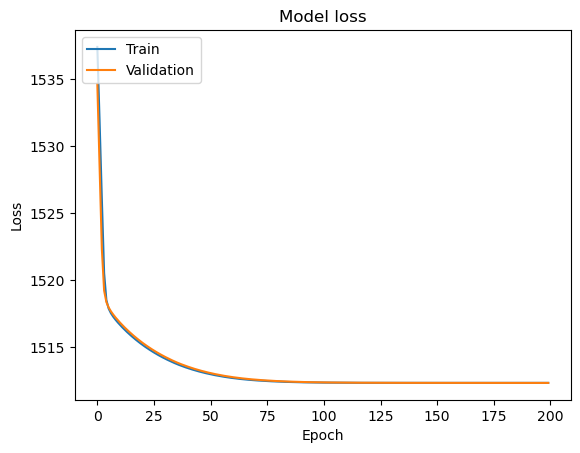

In [27]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()